# 프로젝트 : 자율주행 보조 시스템 만들기

In [1]:
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

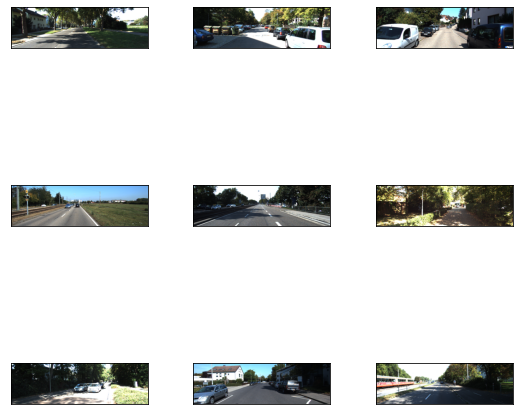

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/ssac10/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
         

In [5]:
TakeDataset = ds_train.take(1)

for example in TakeDataset:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.59, -1.49, -1.57,  1.87], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.43370667, 0.47058776, 0.5043733 , 0.4969404 ],
       [0.44797334, 0.42999196, 0.50936   , 0.45439613],
       [0.46752   , 0.48128825, 0.54474664, 0.49830917],
       [0.45034668, 0.28756845, 0.5093333 , 0.31809178]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.26, 1.6 , 3.56],
       [1.37, 1.63, 3.57],
       [2.26, 1.64, 5.2 ],
       [1.45, 1.53, 3.5 ]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ -0.54,   1.95,  37.22],
       [ -3.86,   2.1 ,  45.94],
       [ -0.16,   2.13,  59.27],
       [-16.19,   2.24,  50.01]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 2, 0])>, 'rotation_y': <tf.Tensor: shape=(4,

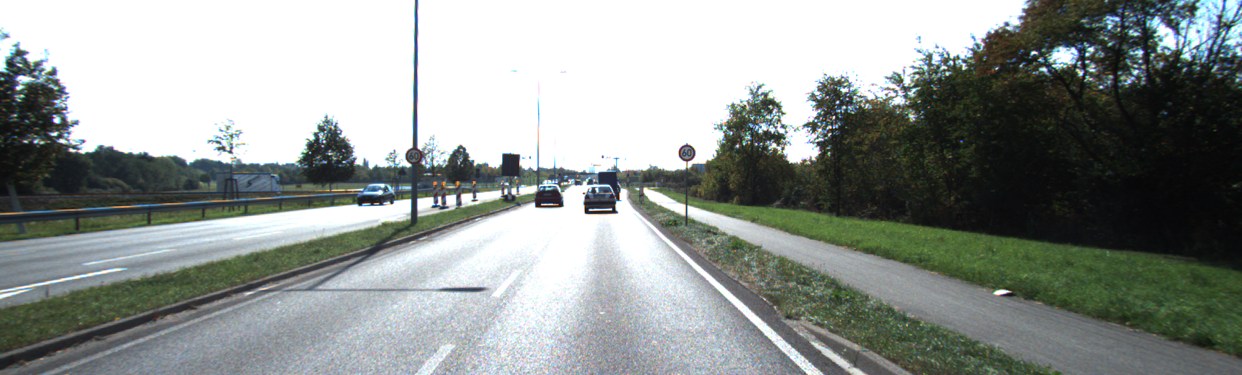

In [6]:
img = Image.fromarray(image.numpy())
img

In [2]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = input_image.size
    print('width:', width, ' height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

width: 1242  height: 375
(4, 4)
[584.47 212.36 617.2  185.86]
[534.05    207.01    564.36    183.98999]
[597.76    199.68001 618.89996 170.72002]
[357.16    206.12    395.06998 184.00002]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7F7125696750>


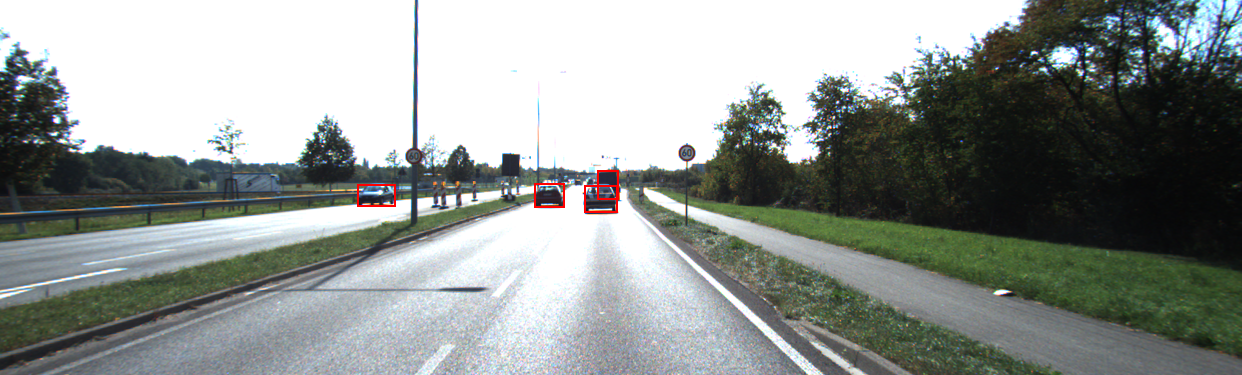

In [8]:
visualize_bbox(img, objects['bbox'].numpy())

In [10]:
data_dir = './data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

In [3]:
# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

In [12]:
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)

100%|██████████| 6347/6347 [11:24<00:00,  9.27it/s]


In [13]:
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

In [14]:
test_csv_path = data_dir + '/kitti_test.csv'

In [15]:
df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)

100%|██████████| 711/711 [01:18<00:00,  9.00it/s]


In [16]:
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

In [17]:
class_txt_path = data_dir + '/classes.txt'

In [4]:
def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

In [19]:
save_class_format(class_txt_path)

# Train

In [20]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-13 21:00:19.022706: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 21:00:20.487904: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-13 21:00:20.521351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 21:00:20.523014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 21:00:20.523088: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 21:00:20.529080: I tensorflow/stream_executor/platform

Epoch 1/50
2021-04-13 21:00:30.864842: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
2021-04-13 21:00:31.775962: W tensorflow/stream_executor/gpu/asm_compiler.cc:81] Running ptxas --version returned 256
2021-04-13 21:00:31.825444: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2021-04-13 21:00:32.214204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-04-13 21:00:42.058007: I tensorflow/stream_executor/cuda/cuda_driver.cc:775] failed to allocate 2.58G (2768099072 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2021-04-13 21:00:56.361313: W tensorflow/core/common_runtime/bfc_allocator.cc:312] Garbage collection: deallocate free memory reg

Epoch 24/50
195/195 [==============================] - ETA: 0s - loss: 1.0195 - regression_loss: 0.7785 - classification_loss: 0.2409
Epoch 00024: saving model to ./snapshots/resnet50_csv_24.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.0195 - regression_loss: 0.7785 - classification_loss: 0.2409
Epoch 25/50
195/195 [==============================] - ETA: 0s - loss: 1.0795 - regression_loss: 0.8226 - classification_loss: 0.2569
Epoch 00025: saving model to ./snapshots/resnet50_csv_25.h5
195/195 [==============================] - 57s 292ms/step - loss: 1.0795 - regression_loss: 0.8226 - classification_loss: 0.2569
Epoch 26/50
195/195 [==============================] - ETA: 0s - loss: 0.9755 - regression_loss: 0.7479 - classification_loss: 0.2276
Epoch 00026: saving model to ./snapshots/resnet50_csv_26.h5
195/195 [==============================] - 57s 292ms/step - loss: 0.9755 - regression_loss: 0.7479 - classification_loss: 0.2276
Epoch 27/50
195/195 [==========

195/195 [==============================] - ETA: 0s - loss: 0.9142 - regression_loss: 0.6918 - classification_loss: 0.2223
Epoch 00040: saving model to ./snapshots/resnet50_csv_40.h5
195/195 [==============================] - 57s 292ms/step - loss: 0.9142 - regression_loss: 0.6918 - classification_loss: 0.2223
Epoch 41/50
195/195 [==============================] - ETA: 0s - loss: 0.9728 - regression_loss: 0.7446 - classification_loss: 0.2282
Epoch 00041: saving model to ./snapshots/resnet50_csv_41.h5
195/195 [==============================] - 57s 293ms/step - loss: 0.9728 - regression_loss: 0.7446 - classification_loss: 0.2282
Epoch 42/50
195/195 [==============================] - ETA: 0s - loss: 0.9702 - regression_loss: 0.7297 - classification_loss: 0.2405
Epoch 00042: saving model to ./snapshots/resnet50_csv_42.h5

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
195/195 [==============================] - 57s 292ms/step - loss: 0.9702 - regression_loss: 

# Inference

In [21]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-13 22:03:03.782995: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 22:03:05.276669: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-13 22:03:05.308801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-13 22:03:05.309875: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-13 22:03:05.309896: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-13 22:03:05.311344: I tensorflow/stream_executor/platform

In [5]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

1 Physical GPUs, 1 Logical GPUs


In [6]:
dir_path = './'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

In [7]:
img_path = './test_set/go_1.png'

In [9]:
# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

[593.35236 174.65726 625.73047 205.50488]
[195.29678 133.04182 364.52972 228.81444]


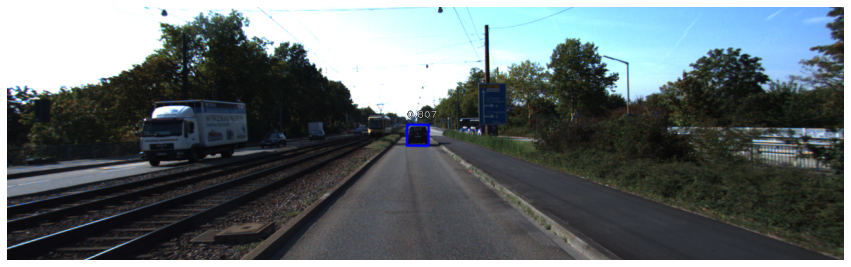

In [10]:
inference_on_image(model, img_path=img_path)

[771.1152  150.01482 844.3341  318.07108]
[773.97614 155.41597 849.08    313.22952]


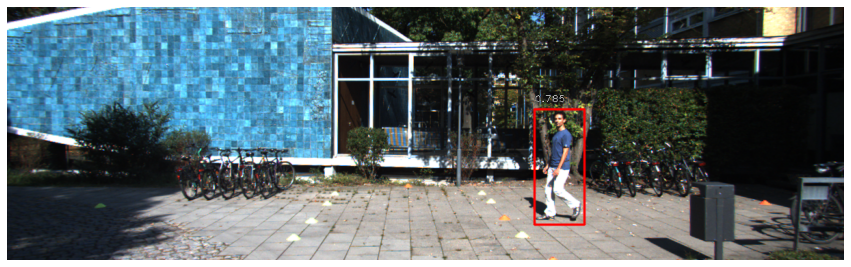

In [30]:
img_path = './test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

In [46]:
def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)
        
    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # 코드 구현
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5:
            break
        if label == 1:
            return "Stop"
        if box[2] - box[0] >= size_limit or box[3] - box[1] >= size_limit:
            return "Stop"
    return "Go"    

In [47]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

In [48]:
test_system(self_drive_assist)

100점입니다.


## 회고록

- Object Detection의 개념 자체는 이해했지만, 모델의 작동 원리를 이해하는 데 조금 어려웠다.
- 다운로드에 너무 오랜 시간이 걸렸다. 이런 부분은 미리 서버에서 받을 수 있도록 해주면 좋을 것 같다.
- 자율주행 보조 시스템을 Object Detection을 이용하여 간단하게 만들어볼 수 있었다.